In [41]:
from langgraph.graph import StateGraph, START, END
import google.generativeai as genai
from typing import Any, Dict, List, TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field


In [42]:
import os
load_dotenv()
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

# Configure the SDK
genai.configure(api_key=GEMINI_API_KEY)
# Create a model instance
model = genai.GenerativeModel("models/gemini-2.5-flash")

# Generate content
# prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n '
# response = model.generate_content(prompt)
# print(response.text)


In [43]:
import json
import re
from typing import Any

def extract_json(text: str) -> dict[str, Any]:
    """
    Extract and parse JSON object from text, ignoring markdown or natural language wrappers.
    """
    # Remove markdown formatting if present
    text = text.strip()
    if text.startswith("```json"):
        text = text[7:]
    if text.endswith("```"):
        text = text[:-3]

    # Find first JSON object using regex
    match = re.search(r'\{.*\}', text, re.DOTALL)
    if match:
        json_str = match.group(0)
        return json.loads(json_str)

    raise ValueError("No valid JSON object found in the response.")


In [44]:

class SentimentAnalysisSchema(BaseModel):
    sentiment_type: Literal['positive', 'negative'] = Field(
        description="The type of sentiment to analyze, either 'positive' or 'negative'."
    )

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')



class ReviewWorkflowState(TypedDict):
    review_text: str = Field(
        description="The text of the review to be analyzed."
    )
    sentiment_type: Literal['positive', 'negative'] = Field(
        description="The sentiment of the review, either 'positive' or 'negative'."
    )

    diagnosis: str = Field(
        description="The diagnosis based on the sentiment analysis."
    )

    response: str = Field(
        description="The response to the review based on the sentiment analysis."
    )

    

In [45]:

# Extract schema structure as a string
def schema_prompt(schema_model: BaseModel) -> str:
    schema = schema_model.model_json_schema()
    # Only keep the "properties" part for a readable prompt
    return json.dumps(schema.get("properties", {}), indent=2)


def FindSentimentType(state: ReviewWorkflowState):
    schema_text = schema_prompt(SentimentAnalysisSchema)

    prompt = f"""
    Analyze the following review and determine the sentiment.

    Review: {state["review_text"]}

    Respond in JSON format matching this schema:
    {schema_text}
    """

    response = model.generate_content(prompt)

    try:
        parsed_data = extract_json(response.text)  # You'll need to define this
        evaluation = SentimentAnalysisSchema.model_validate(parsed_data)
        return {
            "sentiment_type": evaluation.sentiment_type
        }

    except Exception as e:
        print("❌ Error parsing or validating response:")
        print(response.text)
        raise e
    

def PositiveResponse(state: ReviewWorkflowState):
    """
    Generate a positive response based on the review text.
    """
    prompt = f"""Write a warm thank-you message in response to this review:
        \n\n\"{state['review']}\"\n
    Also, kindly ask the user to leave feedback on our website."""

    response = model.generate_content(prompt)

    return {
        "response": response.text
    }


def RunDiagnosis(state: ReviewWorkflowState) -> dict:
    schema_text = schema_prompt(DiagnosisSchema)

    prompt = f"""
    Diagnose the following negative user review.

    Review: "{state["review_text"]}"

    Respond ONLY in JSON format matching this schema:
    {schema_text}
    """

    response = model.generate_content(prompt)

    try:
        parsed_data = extract_json(response.text)  # You’ll need a JSON extractor here
        evaluation = DiagnosisSchema.model_validate(parsed_data)
        return {
           "diagnosis" : evaluation.model_dump()
        }

    except Exception as e:
        print("❌ Error parsing or validating response:")
        print(response.text)
        raise e

def NegativeResponse(state: ReviewWorkflowState):
    """
    Generate response based on the review text.
    """
    diagnosis = state["diagnosis"]

    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
    Write an empathetic, helpful resolution message."""

    response = model.generate_content(prompt)

    return {
        "response": response.text
    }


def Router(state: ReviewWorkflowState) -> Literal["Positive_Response", "Run_Diagnosis"]:
    """
    Route the workflow based on the sentiment type.
    """

    if state["sentiment_type"] == 'positive':
        return "Positive_Response"
    else:
        return "Run_Diagnosis"

In [ ]:
# Define the state graph for the BMI calculator workflow
graph = StateGraph(ReviewWorkflowState)

# Add nodes to the graph
graph.add_node("Find_Sentiment_Type", FindSentimentType)
graph.add_node("Positive_Response", PositiveResponse)
graph.add_node("Negative_Response", NegativeResponse)
graph.add_node("Run_Diagnosis", RunDiagnosis)


# Add edges to the graph
graph.add_edge(START, "Find_Sentiment_Type")
graph.add_conditional_edges("Find_Sentiment_Type", Router)

graph.add_edge("Positive_Response", END)

graph.add_edge("Run_Diagnosis", "Negative_Response")
graph.add_edge("Negative_Response", END)

# Compile the graph
workflow = graph.compile()

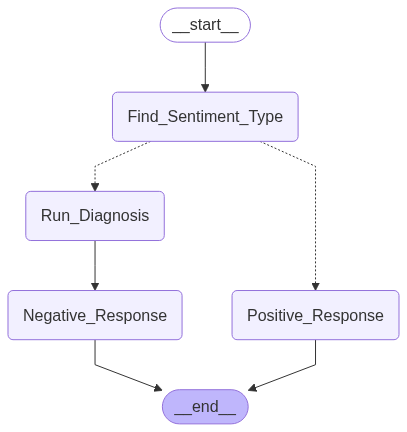

In [47]:
from IPython.display import display, Markdown, Image
Image(workflow.get_graph().draw_mermaid_png())
# display(Markdown("### BMI Calculator Workflow"))

In [48]:
intial_state={
    'review_text': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review_text': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment_type': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Subject: Good News! Your Bug Report - [Brief Issue Description] - Resolved!\n\nHi [User's Name],\n\nThank you for reaching out to us and for reporting this bug. I completely understand how incredibly frustrating and disruptive it must have been to encounter this issue, especially with it being a high-priority matter for you. Please know we took your frustration and urgency to heart.\n\nAs soon as your report came in, we immediately escalated it to our engineering team. I'm happy to inform you that **we have successfully identified the root cause and deployed a fix for the bug you reported!**\n\nThis issue should now be 